<a href="https://colab.research.google.com/github/wzrd13/CI_project_partB/blob/main/CI_Ga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ΥΠΟΛΟΓΙΣΤΙΚΗ ΝΟΗΜΟΣΥΝΗ 
## Μέρος B

> **Βασίλης Χαράλαμπος Αυγερινός ΑΜ: 1054298**   
> **Github link:** [https://github.com/wzrd13/CI_project_2021](https://github.com/wzrd13/CI_project_2021)

Παρακάτω ακολουθεί η αναφορά μαζί με τον κώδικα για το μέρος Β της εργαστηριακής
άσκησης. Στα πειράματα με πληθυσμό 200 λόγο ανεπάρκειας σε υπολογιστή ισχύ (ο χρόνος εκτέλεσης για να τερματίσει μια φορά ο γενετικός αλγόριθμος ήταν μεγαλύτερος από 2 ώρες) έγινε μείωση του πληθυσμού από 200 σε 50.

### **Β1. Σχεδιασμός ΓΑ**

#### α) Κωδικοποίηση
Για την κωδικοποίηση των ατόμων του πληθυσμού επιλέχθηκε ένα array μήκους 784 (=28*28) όσες δηλαδή και οι είσοδοι του νευρωσικού. Οι τιμές που μπορεί να πάρει κάθε θέση είναι "ενεργοποιημένη είσοδος" = 1 ή "απενεργοποιημένη είσοδος" = 0.

#### β) Αρχικός πληθυσμός
Ο αρχικός πληθυσμός αρχικοποιείται τυχαία με τιμές 0 και 1.

#### γ) Συνάρτηση καταλληλόλητας
Η συνάρτηση καταλληλόλητας που επιλέχθηκε είναι η ακόλουθη: 

$eval(Individual) = \frac{CEloss(Individual)*\left( 1 + \frac{sum(Individual)}{784} \right)}{2}$

Αρχικά σε αντίθεση με το accuracy το CEloss εκφράζει καλύτερα το ποσό σίγουρο είναι το δίκτυο για το αποτέλεσμα που δίνει. Για άτομα μέσα στον πληθυσμό που χρησιμοποιούν πολλές εισόδους εισάγετε σφάλμα ανάλογο του loss και συγκεκριμένα αν ένα άτομο χρησιμοποιεί όλες τις εισόδους το σφάλμα που εισάγετε από την χρήση των εισόδων είναι 0.5*CEloss(inidvidual) αρά το συνολικό σφάλμα είναι CEloss. Επόμενος είναι σαν το CEloss να εισάγει μια επιείκεια για μικρές εισόδους. Επίσης μεγαλύτερο eval σημαίνει μικρότερη καταλληλόλητα και αρά το πρόβλημα πρέπει να εκφραστεί ως minimization.


#### δ) Γενετικοί Τελεστές

1. Η συνάρτηση επιλογής που θα χρησιμοποιηθεί για το πρόβλημα είναι του τουρνουά λόγο της αποδοτικότητας του (μπορεί να υλοποιηθεί παράλληλα) σε σχέση με την ρουλέτα με βάση την κατάταξη (απαιτεί sorting) και δεν διατρέχει το κίνδυνο της πρόωρης σύγκλισης όπως η ρουλέτα με βάση την καταλληλόλητα. 
1. Η χρήση ομοιόμορφης διασταύρωσης είναι καταλληλότερη για το πρόβλημα αφού είναι πιο αποτελεσματική στο συνδυασμό σχημάτων από την διασταύρωση μονού και διπλού σημείου συμφώνα με την θεωρία.
1. Η χρήση ελιτισμού είναι θεμιτή καθώς αποτρέπει την μείωση της ποιότητας της βέλτιστης λύσης από την μια γενεά στην άλλη.

### **Β2. Υλοποίηση ΓΑ**

Η υλοποίηση έγινε με Python και τις βιβλιοθήκες numpy, pytorch και deap.

In [3]:
# !pip install torch
# !pip install numpy
# !pip install torchvision
!pip install deap

     |████████████████████████████████| 163kB 9.1MB/s 


In [4]:
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from deap import base, creator
from deap import tools
from tqdm.notebook import trange, tqdm
from matplotlib import pyplot as plt

#### Εκπαίδευση δικτύου σύμφωνα με το Α ερώτημα.

In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
# Download mnist dataset
mnist_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = torchvision.datasets.MNIST(
    './mnist/', 
    train=True, 
    download=True, 
    transform = mnist_transform)

mnist_train_dl = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=32,
    shuffle=True,
    num_workers=2)

mnist_test = torchvision.datasets.MNIST(
    './mnist/', 
    train=False, 
    download=True, 
    transform = mnist_transform)

mnist_test_dl = torch.utils.data.DataLoader(
    mnist_test,
    batch_size=32,
    shuffle=True,
    num_workers=2)

In [7]:
# Define model with 794 hidden layer
class ff_794_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 794)
        self.fc2 = nn.Linear(794, 10)
    def forward(self, x):
        '''Forward pass'''
        x = x.view(-1,1,784)
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        return x

In [8]:
model = ff_794_net().to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.05, momentum= 0.6)
epochs = 4

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ########################################
    #               Training
    # ########################################

    print(f'==== Epoch {epoch_i} ====')

    model.train()

    # For each batch of training data...
    for (x, y) in tqdm(mnist_train_dl):

        # Zero the gradients
        opt.zero_grad()      

        # Forward pass
        pred = model(x.to(device))

        loss = criterion(pred.squeeze(), y.to(device))

        # Backward pass
        loss.backward()  

        # Perform optimization
        opt.step()

PATH = f"/content/mnist_ff_794h_{epochs}e"
torch.save(model.state_dict(), PATH)

==== Epoch 0 ====



==== Epoch 1 ====



==== Epoch 2 ====



==== Epoch 3 ====


In [12]:
def accuracy(preds, labels):
    '''
    Takes predictions and labels and returns accuracy (max 1)
    '''
    prediction = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(prediction == labels) / len(labels)

In [13]:
# ########################################
#               Validation
# ########################################

print(f'==== Validation ====')

model.eval()

# Tracking variables 
total_eval_accuracy = 0

# Evaluate data
for x, y in tqdm(mnist_test_dl):    
    
    with torch.no_grad():        
        # Forward pass
        pred = model(x.to(device))
        pred = pred.squeeze()

    # Move logits and labels to CPU
    pred = pred.detach().cpu().numpy()
    y = y.to('cpu').numpy()

    # Calculate accuracy
    total_eval_accuracy += accuracy(pred, y)

print('')
print("accuracy: ", total_eval_accuracy / len(mnist_test_dl))

==== Validation ====




accuracy:  0.9800319488817891


#### Υλοποίηση Γ.Α.

##### Υλοποίηση κλάσεων και συναρτήσεων γενετικού αλγορίθμου

In [ ]:
def evaluate(model, test_dl, individual):
    '''
    Calculate fitness for given individual

        Parameters:
            model: trained network
            test_dl: dataloader to test individual
            individual: tensor of size 784 states which inputs are activated

        Returns:
            fitness: (CEloss*(1 + sum(individual)/784)/2
    '''
    
    # Init loss function
    criterion = nn.CrossEntropyLoss()

    # Change view of individual tensor
    individual = torch.tensor(individual).view(28,28).float()

    model.eval()

    total_eval_loss = 0

    # Evaluate data for one epoch
    for x, y in test_dl: 

        with torch.no_grad():        
            # Multiply each image by individual
            x = x.to(device) * individual.to(device)

            # Forward pass
            pred = model(x)
            pred = pred.squeeze()

            # Calculate accuracy
            total_eval_loss += criterion(pred, y.to(device))

    # Calculate average loss
    avg_ce_loss = (total_eval_loss/len(test_dl)).item()

    # Count activated input neurons
    ind_sum = sum(individual.view(784)).item()

    # print('ind_sum: ', ind_sum/784)
    # print('avg_loss: ', avg_ce_loss)

    fitness = (avg_ce_loss * (1 + ind_sum/784))/2

    return (fitness,)

In [ ]:
class EndCriterion:
    '''
    Class to decide when to stop G.A

    ...

    Attributes
    ----------
    k : int
        max times condition can be true
    count : int
        counts times condition is true

    Methods
    -------
    __call__(current_loss_list):
        if condtion is true increase count
        returns True if count == k
    '''   

    def __init__(self, k):
        self.k = k
        self.counter = 0
    
    def __call__(self, log_best_ind_fit):
        
        if len(log_best_ind_fit) < 2:
            return False

        # If fitness improved less than 1%
        inc_perc = log_best_ind_fit[-1] - log_best_ind_fit[-2]
        inc_perc = inc_perc / log_best_ind_fit[-2]
        cond = abs(inc_perc) < 0.01

        # If condition is True increase counter    
        if cond: 
            self.counter += 1
        else:
            self.counter = 0
            return False
        
        # If counter value is greater equal than k break
        if self.counter >= self.k:
            return True

        return False

In [ ]:
def run_ga(pop_size, cx_pb, mut_pb, num_gen, toolbox, end_criterion):
    '''
    Calculate fitness for given individual

        Parameters:
            pop_size: population size
            cx_pb: propability of crossover
            mut_pb: propability of mutation
            num_gen: max number of generations
            toolbox(deap.toolbox): container of genetic operations 
            end_criterion(EndCriterion): Criterion to end G.A

        Returns:
            results(dict): {
                'pop': final population, 
                'log': accumulated loss for each gen, 
                'best': best individual
            }
    '''

    print('G.A algorithm started...')
    
    pop = toolbox.population(n=pop_size)

    hof = tools.HallOfFame(1)
    best_ind_fitness = 0
    log_best_ind_fit = []

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    for g in range(num_gen):
        print(f'==== Generation {g} ====')

        hof.update(pop)

        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = [toolbox.clone(item) for item in offspring]

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_pb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mut_pb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # Find best individual and log its fitness
        best_ind = toolbox.sel_best(pop + hof[:])
        log_best_ind_fit.append(best_ind[0].fitness.values[0])

        # Check end criterion
        if end_criterion(log_best_ind_fit):
            print(f'G.A stoped in gen {g+1} because')
            print(f'fitness has not decreased for {end_criterion.k} gens')
            break

        print(f'best ind fitness: {log_best_ind_fit[-1]}')

    return {'pop': pop, 'log': log_best_ind_fit, 'best': best_ind[0]}

##### Test Γενετικού αλγορίθμου.

In [ ]:
# Test fitness function

print("random inputs activated")
print('fitness: ', evaluate(model, mnist_test_dl, np.random.randint(0, high=2, size=(28,28))))

print('')
print("all inputs activated")
print('fitness: ', evaluate(model, mnist_test_dl, np.ones((28,28))))

random inputs activated
fitness:  (0.1498277999973875,)

all inputs activated
fitness:  (0.06220488250255585,)


In [ ]:
# Test genetic algorithm

IND_SIZE = 784

# register deap functions for the g.a problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Init population with random zeros and ones
toolbox = base.Toolbox()
toolbox.register("attribute", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attribute, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operrands
toolbox.register("mate", tools.cxUniform, indpb=0.2)
toolbox.register("mutate", tools.mutFlipBit, indpb=2/784)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("evaluate", evaluate, model, mnist_test_dl)
toolbox.register("sel_best", tools.selBest, k=1)

# Run G.A
# pop = run_ga(20, 0.6, 0.01, 20, toolbox, EndCriterion(10))

##### Υλοποίηση βοηθητικών συναρτήσεων.

In [ ]:
# Caluculate mean of lists with different sizes
# From stackOverflow -> https://stackoverflow.com/a/59281468
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

In [ ]:
# Plot individual fitness with optional save
def plot(y, error, title, path=None):

    # Range x = generations
    x = range(1, len(y)+1)

    # Create subplots
    plt.title(title, fontsize=16)
    
    # Show axes labels
    plt.xlabel('generation')
    plt.ylabel('loss')

    # Plot values
    plt.plot(x, y)
    plt.fill_between(x, y-error, y+error, alpha=0.2)
    plt.xticks(x, x)

    # Save
    if path:
        plt.savefig(f'{path}/{title}.png', dpi=300, bbox_inches='tight')

    # Show
    plt.show()

### **Β3. Αξιολόγηση και Επίδραση Παραμέτρων**

In [ ]:
import statistics
import json

# Define genetic algorithm parameters
NUM_OF_GEN = 20
TIMES = 3
INC = 6

# pop_size, cx_pb, mut_pb
parameter_list = [
    #(20, 0.6, 0.00),
    #(20, 0.6, 0.01),
    #(20, 0.6, 0.10),
    #(20, 0.9, 0.01),
    #(20, 0.1, 0.01),
    (50, 0.6, 0.00),
    (50, 0.6, 0.01),
    (50, 0.6, 0.10),
    (50, 0.9, 0.01),
    (50, 0.1, 0.01)          
]

for i, (pop_size, cx_pb, mut_pb) in enumerate(parameter_list):

    print(f'==== Run {i+1} ====')
    print('Parameters:')
    print(f'pop_size={pop_size}, cx_pb={cx_pb}, mut_pb={mut_pb}')

    # Init list to hold results for each run
    results = []

    # Run G.A _ times to take average fitness
    for run in trange(TIMES):

        results.append(
            run_ga(pop_size, 
                   cx_pb, 
                   mut_pb, 
                   NUM_OF_GEN, 
                   toolbox, 
                   EndCriterion(3))
        )

    # Get loss for each gen
    log = [list(r['log']) for r in results]

    # Get average gen
    avg_gen = [len(l) for l in log]
    avg_gen = statistics.mean(avg_gen)

    # Get average best individual
    avg_b_ind = [r['best'].fitness.values[0] for r in results]
    avg_b_ind = statistics.mean(avg_b_ind)

    # Calculate mean of loss
    y, error = tolerant_mean(log)

    # Save data
    r_file = f'/content/drive/MyDrive/mnist_ga/results/reduced_r{i+INC}.json'
    with open(r_file, 'w') as fout:
        json.dump({
            'avg_gen': avg_gen, 
            'avg_b_ind': avg_b_ind,
            'plot_v': (y.tolist(), error.tolist()),
            'best_inds': [(r['best'], r['best'].fitness.values[0]) for r in results]
        }, fout)

    # Plot avg loss and save
    plot(y, 
         error, 
         f'average_loss_reduced_{i+INC}',
         path='/content/drive/MyDrive/mnist_ga/plots')

#### α) Πινακας αποτελεσματων

In [ ]:
res_list = [
    [20, 0.6, 0.00, 4, 0.097423],
    [20, 0.6, 0.01, 4, 0.103355],
    [20, 0.6, 0.10, 4, 0.093105],
    [20, 0.9, 0.01, 4, 0.094460],
    [20, 0.1, 0.01, 4, 0.108623],
    [50, 0.6, 0.00, 12, 0.079964],
    [50, 0.6, 0.01, 19, 0.066677],
    [50, 0.6, 0.10, 12.6, 0.0715276],
    [50, 0.9, 0.01, 9.3, 0.0772074],
    [50, 0.1, 0.01, 6.3, 0.091887]          
]

res_columns = [
    "ΜΕΓΕΘΟΣ ΠΛΗΘΥΣΜΟΥ", 
    "ΠΙΘΑΝΟΤΗΤΑ ΔΙΑΣΤΑΥΡΩΣΗΣ", 
    "ΠΙΘΑΝΟΤΗΤΑ ΜΕΤΑΛΛΑΞΗΣ", 
    "ΜΕΣΗ ΤΙΜΗ ΒΕΛΤΙΣΤΟΥ", 
    "ΜΕΣΟΣ ΑΡΙΘΜΟΣ ΓΕΝΕΩΝ"
]

res_table = pd.DataFrame(data=res_list, columns=res_columns)
display(res_table)

,ΜΕΓΕΘΟΣ ΠΛΗΘΥΣΜΟΥ,ΠΙΘΑΝΟΤΗΤΑ ΔΙΑΣΤΑΥΡΩΣΗΣ,ΠΙΘΑΝΟΤΗΤΑ ΜΕΤΑΛΛΑΞΗΣ,ΜΕΣΗ ΤΙΜΗ ΒΕΛΤΙΣΤΟΥ,ΜΕΣΟΣ ΑΡΙΘΜΟΣ ΓΕΝΕΩΝ
0,20,0.6,0.00,4.0,0.097423
1,20,0.6,0.01,4.0,0.103355
2,20,0.6,0.10,4.0,0.093105
3,20,0.9,0.01,4.0,0.094460
4,20,0.1,0.01,4.0,0.108623
5,50,0.6,0.00,12.0,0.079964
6,50,0.6,0.01,19.0,0.066677
7,50,0.6,0.10,12.6,0.071528
8,50,0.9,0.01,9.3,0.077207
9,50,0.1,0.01,6.3,0.091887


#### β) Καμπύλες εξέλιξης

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = []

for i in range(1,6):
    path = f'/content/drive/MyDrive/mnist_ga/plots/average_loss_{i}.png'
    img.append(mpimg.imread(path))

for i in range(6,11):
    path = f'/content/drive/MyDrive/mnist_ga/plots/average_loss_reduced_{i}.png'
    img.append(mpimg.imread(path)) 

In [ ]:
path = '/content/drive/MyDrive/mnist_ga/plots/grid.png'

f, axarr = plt.subplots(5,2)

for i in range(10):
    axarr[i%5,i%2].imshow(img[i]);
    axarr[i%5,i%2].axis('off')

plt.axis('off')
plt.savefig(path, dpi=300, bbox_inches='tight')

![](https://drive.google.com/uc?id=1Q9ysd3-P2gHLAuBuKZ-MyhGEORhgKUI1)

#### γ) συμπεράσματα

Αρχικά το μέγεθος του πληθυσμού παίζει πολύ σημαντικό ρολό στην σύγκληση του αλγορίθμου. Μεγαλύτεροι πληθυσμοί συγκλίνουν σε περισσότερες γενιές πετυχαίνοντας έτσι κατά μέσο ορό μικρότερο loss από μικρους πληθυσμούς. Πολύ σημαντικό ρολό στην σύγκλιση έχει και η πιθανότητα διασταύρωσης καθώς με μικρές τιμές ο αλγόριθμος δεν μπορεί να εξερευνήσει αποδοτικά τον χώρο λύσεων.  Τέλος από τα αποτελέσματα ο ρόλος της πιθανότητας μετάλλαξής ως προς την ταχύτητα σύγκλισης δεν είναι ξεκάθαρος ωστόσο πειράματα με πιθανότητα μετάλλαξης 0 αποδίδουν ελαφρός χειροτέρα (μεγαλύτερο loss) κατά μεσο ορο.

### **Β4. Αξιολόγηση ΤΝΔ**

#### α) Σύγκριση απόδοσης

In [23]:
# Load result file
import json

EXPERIMENT = 7
RUN = 1
path = f'/content/drive/MyDrive/mnist_ga/results/reduced_r{EXPERIMENT}.json'

with open(path) as f:
  res_7 = json.load(f)

best_ind = res_7['best_inds'][RUN][0]
best_ind = torch.tensor(best_ind)

activated_neurons = sum(best_ind)

best_ind = best_ind.view(28,28).float()

In [ ]:
# ########################################
#               Validation
# ########################################

print(f'==== Validation ====')

#best_ind = torch.tensor(best_ind).view(28,28).float()

model.eval()

# Tracking variables 
total_eval_accuracy = 0

# Evaluate data
for x, y in tqdm(mnist_train_dl):    
    
    with torch.no_grad():        
        # Multiply each image by individual
        x = x.to(device) * best_ind.to(device)

        # Forward pass
        pred = model(x.to(device))
        pred = pred.squeeze()

    # Move logits and labels to CPU
    pred = pred.detach().cpu().numpy()
    y = y.to('cpu').numpy()

    # Calculate accuracy
    total_eval_accuracy += accuracy(pred, y)

print('')
print(
    f'''
    experiment: {EXPERIMENT}
    activated input neurons: {activated_neurons}
    fittness: {res_7['best_inds'][RUN][1]}
    accuracy:  {total_eval_accuracy / len(mnist_train_dl)}
    '''
)

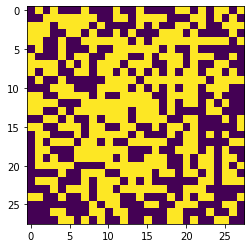

In [24]:
# Show active input neurons of given individual
plt.imshow(best_ind)

1.	Το βέλτιστο δυτικό που προέκυψε από τον γενετικό αλγόριθμο πετυχαίνει accuracy 0.96 ελαφρός χειρότερο από το αρχικό δίκτυο (accuracy = 0.98) του μέρους Α.

2.	Η επίδραση της μειώσεις το χαρακτηριστικών είναι πολύ μικρή και με περεταίρω εκπαίδευση αναμένετε να μειωθεί ακόμα περισσότερο. Τα χαρακτηριστικά που διαγράφονται τείνουν να είναι τυχαία κατανεμημένα με μια ελαφριά προτίμηση προς το περίγραμμά της εικόνας. 

3.	Το ενδεχόμενο υπερπροσαρμογής στα δεδομένα ελέγχου δεν επιβεβαιώνετε από το testing καθώς το δίκτυο πετυχαίνει σε πολλές περιπτώσεις καλύτερο accuracy στο training set.


#### β) Επανεκπαίδευση και σύγκριση απόδοσης

1.	Επανεκπαιδεύοντας το δίκτυο με μειόμενο αριθμό εισόδων περνούμε accuracy 98% ίδιο με το αρχικό μοντέλο. Αρά το δίκτυο έχει επαρκή γενικευτική ικανότητά.

2.  Η επιλογή χαρακτηριστικών πλέον δεν επηρεάζει το accuracy του δικτύου.

3.	Το μοντέλο εξακολουθεί να μην εμφανίζει υπερπροσαρμογή στα δεδομένα.

In [25]:
# Define model with 794 hidden layer
class ff_ga_794_net(nn.Module):
    def __init__(self, activated_neurons):
        super().__init__()
        self.fc1 = nn.Linear(activated_neurons, 794)
        self.fc2 = nn.Linear(794, 10)
    def forward(self, x):
        '''Forward pass'''
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        return x

In [ ]:
import json
EXPERIMENT = 7
RUN = 1
path = f'/content/drive/MyDrive/mnist_ga/results/reduced_r{EXPERIMENT}.json'

with open(path) as f:
  res_7 = json.load(f)

best_ind = res_7['best_inds'][RUN][0]
activated_neurons = sum(best_ind)

model = ff_ga_794_net(activated_neurons).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.05, momentum= 0.6)
epochs = 4

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ########################################
    #               Training
    # ########################################

    print(f'==== Epoch {epoch_i} ====')

    best_ind = torch.tensor(best_ind).float()

    model.train()

    # For each batch of training data...
    for (x, y) in tqdm(mnist_train_dl):

        # Zero the gradients
        opt.zero_grad()      

        # Forward pass
        x = x.view(-1,1, 784)
        x = torch.masked_select(x, best_ind>0)
        x = x.view(-1,1, activated_neurons)

        pred = model(x.to(device))

        loss = criterion(pred.squeeze(), y.to(device))

        # Backward pass
        loss.backward()  

        # Perform optimization
        opt.step()

PATH = f"/content/mnist_ff_794h_{epochs}e"
torch.save(model.state_dict(), PATH)

In [29]:
# ########################################
#               Validation
# ########################################

print(f'==== Validation ====')

model.eval()

# Tracking variables 
total_eval_accuracy = 0

# Evaluate data
for x, y in tqdm(mnist_test_dl):    
    
    with torch.no_grad():        
        # Multiply each image by individual
        x = x.view(-1,1, 784)
        x = torch.masked_select(x, best_ind>0)
        x = x.view(-1,1, activated_neurons)

        # Forward pass
        pred = model(x.to(device))
        pred = pred.squeeze()

    # Move logits and labels to CPU
    pred = pred.detach().cpu().numpy()
    y = y.to('cpu').numpy()

    # Calculate accuracy
    total_eval_accuracy += accuracy(pred, y)

print(
    f'''
    experiment: {EXPERIMENT}
    activated input neurons: {activated_neurons}
    fittness: {res_7['best_inds'][RUN][1]}
    accuracy:  {total_eval_accuracy / len(mnist_test_dl)}
    '''
)

==== Validation ====




    experiment: 7
    activated input neurons: 417
    fittness: 0.06424095224094938
    accuracy:  0.9788338658146964
    
